In [1]:
from Weak_LWE_PKC import LWE_Encrypt, LWE_Decrypt_Weak
import itertools
import numpy as np

### 1. Testing out the Cryptosystem

In [2]:
# Initialize PKC with parameters
lwe_d = LWE_Decrypt_Weak(n=3, q=17, max_error=1, list_size=12)
MESSAGE = [1, 1, 0]
print(f"message = {MESSAGE}")

message = [1, 1, 0]


In [3]:
# Get public keys
A_list, T_list, q, max_error = lwe_d.get_public_keys()
print(A_list)
print(T_list)
print(q)
print(max_error)

[[ 0  1 16]
 [ 0 16 16]
 [ 1 16  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1 16  0]
 [ 1  0  0]
 [ 0  1  0]
 [ 0  0  0]
 [ 1  0  0]
 [ 1  1  0]]
[ 2  0 16  1 16  0 16  0  1 16 16  1]
17
1


In [4]:
# Encrypt Message
lwe_e = LWE_Encrypt(A_list, T_list, q, max_error)
A_new, T_send = lwe_e.encrypt_message(MESSAGE)
print(f"A_new = {A_new}\nT_send = {T_send}")

A_new = [array([2, 0, 0]), array([2, 2, 0]), array([2, 0, 0])]
T_send = [8, 10, 0]


In [5]:
# Decrypt Message
decrypted_message = lwe_d.decrypt_message(A_new, T_send)
print(f"decrypted_message = {decrypted_message}")

decrypted_message = [1, 1, 0]


### Noise Reduction Attack

A brute force attack when the entropy of A & secret is small compared to q

In [6]:
# Initialize PKC with parameters
lwe_d = LWE_Decrypt_Weak(n=3, q=17, max_error=1, list_size=5)
# Get public keys
A_list_og, T_list_og, q, max_error = lwe_d.get_public_keys()
print(A_list_og)
print(T_list_og)
print(q)
print(max_error)

[[ 0 16  1]
 [ 0  1  0]
 [ 0  1  0]
 [ 0  0  0]
 [16  0  0]]
[16  1  0  0  1]
17
1


In [7]:
# Replace A_list & T_list with negative numbers (e.g., 16 will become -1 for q = 17)
make_negative = lambda x, q: x if x <= (q//2) else x - q
A_list = [[make_negative(x, q) for x in A_sample] for A_sample in A_list_og]
T_list = [make_negative(x, q) for x in T_list_og]

# Take any n equations and solve them
combination_indexes = list(itertools.combinations(range(len(T_list)), 3))  # n is hardcoded here
possible_secrets = []
for indexes in combination_indexes:
    As = np.array([A_list[index] for index in indexes]).astype(float)
    Ts = np.array([T_list[index] for index in indexes]).astype(float)
    # print(f"As = {As}")
    # print(f"Ts = {Ts}")
    try:
        possible_s = np.linalg.solve(As, Ts)
        possible_secrets.append(possible_s.tolist())
    except np.linalg.LinAlgError as err:
        # Ignore cases which dont converge
        pass

print(possible_secrets)

[[-1.0, 1.0, 0.0], [-1.0, 0.0, -1.0]]


In [8]:
# Take mean of all possible points
x, y, z = zip(*possible_secrets)
estimated_secret = np.array([round(np.mean(x)), round(np.mean(y)), round(np.mean(z))])
print("Estimated Secret =", estimated_secret % q)

# Encrypt Message
MESSAGE = [1, 1, 0]
lwe_e = LWE_Encrypt(A_list_og, T_list_og, q, max_error)
A_new, T_send = lwe_e.encrypt_message(MESSAGE)
print(f"Message Encrypted = {MESSAGE}")

# Decrypt using estimated secret
def decrypt_bit(A_new, T_sent, q, estimated_secret):
    # Find T_ideal
    T_ideal = np.matmul(A_new, estimated_secret) % q
        
    # T_sent - T_ideal
    Message_Draft = T_sent - T_ideal

    # Get final Message
    final_message = ((Message_Draft + (q//4)) % q) // (q//2)

    return final_message
    
def decrypt_message(A_new_list, T_sent_list, q, estimated_secret):
    final_message = []
    for i in range(len(T_sent_list)):
        final_message.append(decrypt_bit(A_new_list[i], T_sent_list[i], q, estimated_secret))
        
    return final_message

print(f"Decrypted Message = {decrypt_message(A_new_list=A_new, T_sent_list=T_send, q=q, estimated_secret=estimated_secret)}")
print(f"Real Secret = {lwe_d.secret}")

Estimated Secret = [16  0  0]
Message Encrypted = [1, 1, 0]
Decrypted Message = [1, 1, 0]
Real Secret = [0 0 0]


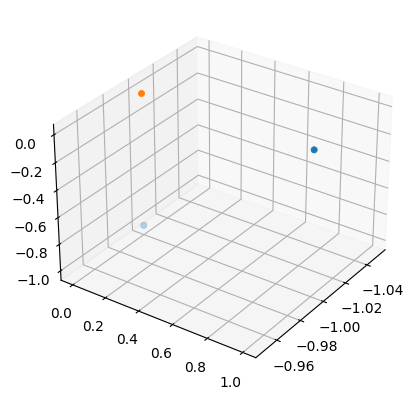

In [9]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, linewidth=0.5)
ax.scatter(estimated_secret[0], estimated_secret[1], estimated_secret[2], 'red', linewidths=0.5)
ax.view_init(30, 35)

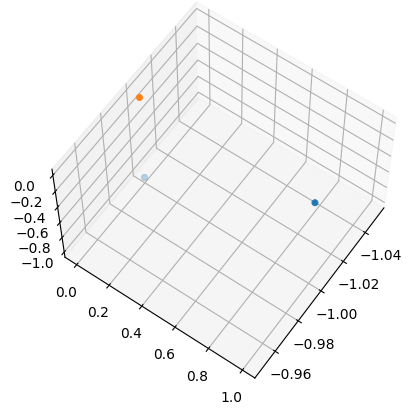

In [10]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, linewidth=0.5)
ax.scatter(estimated_secret[0], estimated_secret[1], estimated_secret[2], 'red', linewidths=0.5)
ax.view_init(60, 35)

Text(0.5, 1.0, 'z vs x')

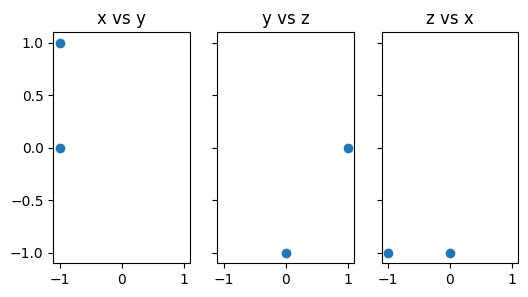

In [11]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6,3))
ax[0].plot(x, y, linestyle='none', marker='o')
ax[0].set_title("x vs y")
ax[1].plot(y, z, linestyle='none', marker='o')
ax[1].set_title("y vs z")
ax[2].plot(z, x, linestyle='none', marker='o')
ax[2].set_title("z vs x")